# Random Points on a Circle Riddler

Last week's [Riddler](https://fivethirtyeight.com/features/what-comes-after-840-the-answer-may-surprise-you/) was about determining the probability that randomly distributed points on a circle all belong to a common same half-circle. It seemed like it should be pretty easy to solve by hand, but for whatever reason I couldn't piece out a  solution. Instead, I settled for simulating the problem and making some pretty explanatory pictures.

Here's the prompt copied verbatim from [FiveThirtyEight](https://fivethirtyeight.com/) for April 19:

*If $N$ points are generated at random places on the perimeter of a circle, what is the probability that you can pick a diameter such that all of those points are on only one side of the newly halved circle?*

## Determining When Points Belong to the Same Hemisphere

To simulate the solution, I used a simple geometric trick to detect when points lie in the same half-circle. Let $C$ denote the unit circle in $\mathbb{R}^2$. Then, $p_1,\ldots, p_n \in C$ belong to the same hemisphere of $C$ just in case there exists $i \in \{1,\ldots,n\}$ for which either $\min\left(\langle q_i, p_j \rangle\right) \geq 0$ or $\max\left(\langle q_i, p_j \rangle\right) \leq 0$, where $q_i$ is a non-zero perpendicular vector to $p_i$. 

To see this, the points $p_k$ $k=1,\ldots,n$ lie in the same half-circle iff we can split the circle $C$ along a line $l$ passing through the origin and one of the points $p_i$, so that all points sit on the same side of the line $l$. In turn, all points $p_i$ lie on the same side of $l$ if they all share the same sign when projected onto a normal $q_i$ to $l$. Finally, note that $q_i$ will be normal to $l$ just in case $q_i$ is perpendicular to $p_i$ - since $l$ passes through $0$ and $p_i$.

The function below uses this observation to determine whether angles $\theta_i$, corresponding to points $p_i$, lie in the same half-circle.  It returns a tuple with a flag indicating whether a splitting line $l$ exists (or not), and the index of the point $p_i$ through which $l$ passes. It will return `NaN` for this index if no split exists. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def thetas_on_same_half(thetas):
    thetas = thetas.flatten()
    n_thetas = thetas.size
    ps = np.array([np.cos(thetas), np.sin(thetas)]).T
    
    for i in range(n_thetas):
        q = np.array([ps[i,1], -ps[i,0]]).reshape((2,1))
        
        # be careful with the dot product p_i * q_i
        # this will only be zero to machine precision, 
        # so it may be slightly positive or negative
        # make it actually zero to avoid this
        same_side_as_q = np.dot(ps, q)
        same_side_as_q[i] = 0.0
        
        proj_min = np.min(same_side_as_q)
        proj_max = np.max(same_side_as_q)
        
        if proj_min >= 0 or proj_max <= 0:
            return True, i
    return False, np.nan

## Splitting Visualizations 

Below, I wanted to get a sense (visually) of the frequency with which the points belong to the same hemisphere. So, for I simulated 100 draws of $n$ random points for $n=2,\ldots,5$ points. For each draw, I'll plot the points on a circle, and if there is a line splitting the circle into a hemisphere containing all of the points and an empty hemisphere, then I'll draw the splitting line (in green) running through the point $p_i$ described as above.

In [3]:
def plot_splits(n_points, n_row):
    n_runs = n_row*n_row
    thetas  = 2.0 * np.pi * np.random.rand(n_points, n_runs)
    results = np.zeros(n_runs, dtype='bool') 
    idx = np.zeros(n_runs)
    ivals = []
    
    fig, axs = plt.subplots(n_row, n_row, figsize=(6,6))
    
    theta_circle = np.linspace(0, 2*np.pi, 1000)
    x_circle = np.cos(theta_circle)
    y_circle = np.sin(theta_circle)
    
    for i in range(n_runs):
        results[i], idx[i] = thetas_on_same_half(thetas[:, i])
        
    for i in range(n_runs):        
        ax = axs[i % n_row, int(i / n_row)]    
        if results[i]:                 
            idx_split = int(idx[i])
            theta_split = thetas[idx_split, i]
            x1, y1 = np.cos(theta_split), np.sin(theta_split)
            ax.plot([x1,-x1],[y1,-y1], c='g')
        
        ax.scatter(np.cos(thetas[:,i]), np.sin(thetas[:,i]), c='C0')
        ax.plot(x_circle, y_circle, c='k')
        ax.set_xlim(-1.01, 1.01)    
        ax.set_ylim(-1.01, 1.01)
        ax.set_xticks([],[])
        ax.set_yticks([],[])    
        fig.suptitle("Examples for n = {0} Points \n(Splits exist in {1}/{2} cases)".format(n_points, 
                                                                             len(results[results == True]),
                                                                             n_runs))
    plt.show()

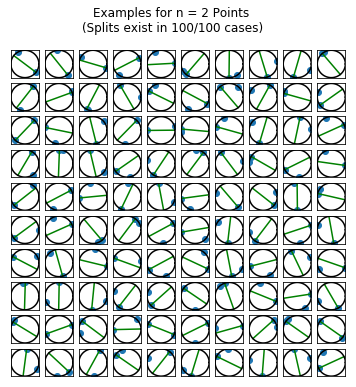

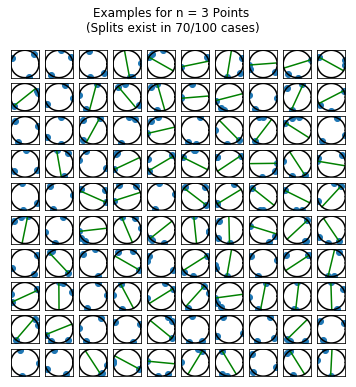

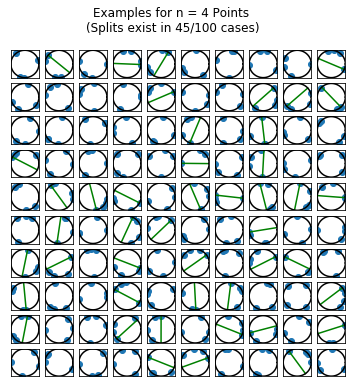

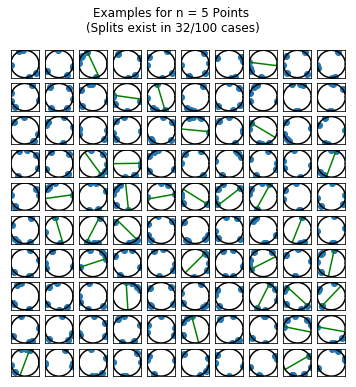

In [4]:
np.random.seed(797979)
for n_points in range(2, 5+1):
    plot_splits(n_points = n_points, n_row = 10)

## Simulating the Solution

Since I'm not going to be solving the problem analytically, the only thing that is left to do is to estimate the splitting probabilities for a range of different points. I'll estimate the probabilities for $n = 2,\ldots,20$ points, using 25,000 draws of $n$ random points for each $n$.

In [5]:
def estimate_split_prob(n_points, n_runs):
    thetas  = 2.0 * np.pi * np.random.rand(n_points, n_runs)
    results = np.zeros(n_runs, dtype='bool') 

    for i in range(n_runs):
        results[i], _ = thetas_on_same_half(thetas[:, i])
    p = len(results[results]) / n_runs
    return p

In [6]:
n_runs = 25000
n_points = np.arange(2, 20+1, dtype='int')
probs = np.zeros(n_points.size)

np.random.seed(797979)
for i, nps in enumerate(n_points):
    probs[i] = estimate_split_prob(nps, n_runs)

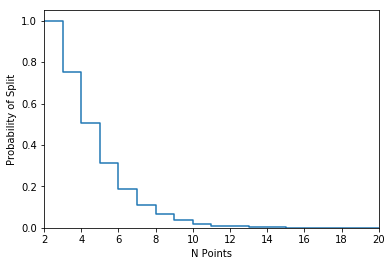

In [7]:
fig, ax = plt.subplots()
ax.plot(n_points, probs,drawstyle="steps-post")
ax.set_xlim(np.min(n_points), np.max(n_points))
ax.set_ylim(0, 1.05)
ax.set_xlabel("N Points")
ax.set_ylabel("Probability of Split")
plt.show()

In [8]:
print("N_pts\tProbability of Split")
print("-------------")
for i, nps in enumerate(n_points):
    print("{0}\t{1}".format(nps, probs[i]))

N_pts	Probability of Split
-------------
2	1.0
3	0.753
4	0.50792
5	0.31324
6	0.18852
7	0.11008
8	0.06452
9	0.037
10	0.01952
11	0.01088
12	0.00644
13	0.00312
14	0.00172
15	0.00076
16	0.0004
17	0.00028
18	8e-05
19	4e-05
20	0.0
